In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPool1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import json

In [2]:
with open("intents.json") as text:
    data = json.load(text)

In [3]:
tags = []
patterns = []
responses = {}
for intent in data["intents"]:
    responses[intent["tag"]] = intent["responses"]
    for lines in intent["patterns"]:
        patterns.append(lines)
        tags.append(intent["tag"])


In [4]:
data = pd.DataFrame({"inputs": patterns, "tags": tags})
data

,inputs,tags
0,Hi,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting
5,Bye,goodbye
6,See you later,goodbye
7,Goodbye,goodbye
8,Thanks,thanks
9,Thank you,thanks


In [5]:
data = data.sample(frac=1)

In [6]:
import string
data["inputs"] = data["inputs"].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data["inputs"] = data["inputs"].apply(lambda wrd: "".join(wrd))
data

,inputs,tags
2,is anyone there,greeting
10,thats helpful,thanks
3,hello,greeting
6,see you later,goodbye
8,thanks,thanks
1,how are you,greeting
5,bye,goodbye
9,thank you,thanks
4,good day,greeting
7,goodbye,goodbye


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data["inputs"])
train = tokenizer.texts_to_sequences(data["inputs"])

from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data["tags"])

In [8]:
input_shape = x_train.shape[1]
print(input_shape)

3


In [9]:
vocabulary = len(tokenizer.word_index)
print("Number of unique words are: ", vocabulary)
output_length = le.classes_.shape[0]
print("Output Length: ", output_length)

Number of unique words are:  18
Output Length:  3


In [10]:
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 10)(i)
x = LSTM(300, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length, activation="softmax")(x)
model = Model(i, x)

In [11]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [12]:
train = model.fit(x_train, y_train, epochs=300)

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 1.0987 - accuracy: 0.3636
Epoch 2/200
1/1 [==============================] - 0s 43ms/step - loss: 1.0964 - accuracy: 0.4545
Epoch 3/200
1/1 [==============================] - 0s 36ms/step - loss: 1.0939 - accuracy: 0.4545
Epoch 4/200
1/1 [==============================] - 0s 42ms/step - loss: 1.0915 - accuracy: 0.4545
Epoch 5/200
1/1 [==============================] - 0s 41ms/step - loss: 1.0888 - accuracy: 0.4545
Epoch 6/200
1/1 [==============================] - 0s 45ms/step - loss: 1.0859 - accuracy: 0.4545
Epoch 7/200
1/1 [==============================] - 0s 36ms/step - loss: 1.0828 - accuracy: 0.4545
Epoch 8/200
1/1 [==============================] - 0s 39ms/step - loss: 1.0795 - accuracy: 0.4545
Epoch 9/200
1/1 [==============================] - 0s 46ms/step - loss: 1.0758 - accuracy: 0.4545
Epoch 10/200
1/1 [==============================] - 0s 43ms/step - loss: 1.0719 - accuracy: 0.4545
Epoch 11/200
1/1 [===

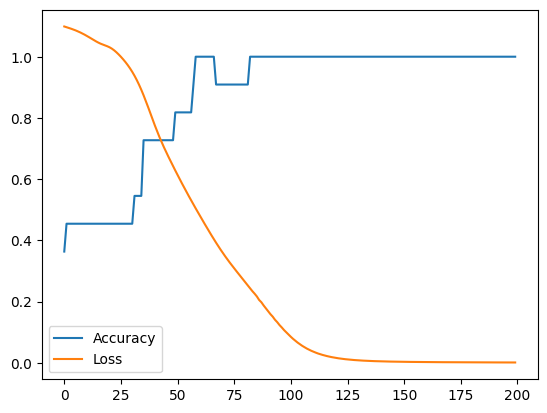

In [13]:
plt.plot(train.history["accuracy"], label="Accuracy")
plt.plot(train.history["loss"], label="Loss")
plt.legend()

In [21]:
import random

i = 0
while i < 5:
    texts_p = []
    prediction_input = input("You : ")
    
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = "".join(prediction_input)
    texts_p.append(prediction_input)

    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = tf.keras.preprocessing.sequence.pad_sequences([prediction_input], input_shape)

    output = model.predict(prediction_input)
    output = output.argmax()

    response_tag = le.inverse_transform([output])[0]

    
    i=i+1
    if response_tag == "googbye":
        break
    else:
        print("Bot : ", random.choice(responses[response_tag]))

[[18]]
1/1 [==============================] - 0s 36ms/step
Bot :  Good to see you again
[[13]]
1/1 [==============================] - 0s 41ms/step
Bot :  Have a nice day
[[]]
1/1 [==============================] - 0s 42ms/step
Bot :  See you later, thanks for visiting
